In [36]:
import yaml
import sys
import os 
import tensorflow as tf
sys.path.append('..')
import pickle
from sklearn.cluster import AgglomerativeClustering

import imp
import ml_pipeline
imp.reload(ml_pipeline)

<module 'ml_pipeline' from '../ml_pipeline/__init__.py'>

In [30]:
from ml_pipeline.audio import *
from ml_pipeline.dtw import * 
from ml_pipeline.sequence_hashing import *
from tensorflow.keras.models import *
from ml_pipeline.structured import * 

In [ ]:
re          = RegionExtractors(0)
overlapping = []
for file in tf.io.gfile.listdir('../models/v2_lstm_v8/'):        
    if file.startswith("embedding") and file.endswith(".csv"):
        path = "{}/{}".format('../models/v2_lstm_v8/', file)
        print("\tReading {}".format(path))
        header                = ["filename", "start", "stop", "type", "embedding"]
        df                    = pd.read_csv(path, sep="\t", header = None, names=header)
        signals               = df[df['type'] >= 1]
        signals['embedding']  = df['embedding'].apply(
            lambda x: np.array([float(i) for i in x.split(",")]))
        annotated             = [(row['start'], row['stop'], row['filename'], row['embedding'])
                                 for _ , row in signals.iterrows()]
        overlapping += groupBy(annotated, re.overlap)    

In [ ]:
pickle.dump(overlapping, open('overlapping.pkl', 'wb'))

In [11]:
min_th = 4
max_th = 250
overlapping = [x for x in pickle.load(open('overlapping.pkl', 'rb')) if len(x[3]) > min_th and len(x[3]) < max_th]
sequences = [np.stack(s) for _, _, _, s in overlapping]
print(len(sequences), len(overlapping))

20682 20682


In [12]:
assignments = similarity_bucketing(sequences, 4, 5)
clusters = max(assignments) + 1
print(clusters)

611


In [13]:
counts = np.zeros(clusters)
for i in assignments:
    counts[i] += 1

Percentile 5:  2.0
Percentile 10: 3.0
Percentile 50: 13.0
Percentile 90: 80.0
Percentile 95: 124.5


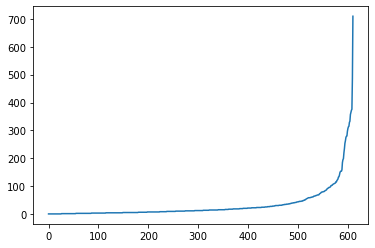

In [24]:
import matplotlib.pyplot as plt

print("Percentile 5:  {}".format(np.percentile(counts, 5)))
print("Percentile 10: {}".format(np.percentile(counts, 10)))
print("Percentile 50: {}".format(np.percentile(counts, 50)))
print("Percentile 90: {}".format(np.percentile(counts, 90)))
print("Percentile 95: {}".format(np.percentile(counts, 95)))

plt.plot(sorted(counts))
plt.show()

In [26]:
by_assignment = {}
for o, s in zip(overlapping, assignments):
    if s not in by_assignment:
        by_assignment[s] = []
    by_assignment[s].append(o)

In [ ]:
with open('clustering.csv', "w") as fp:
    max_dist = 5.0
    cur = 0
    for i, overlapping in by_assignment.items():
        max_len = int(max([len(e) for _, _, _, e in overlapping]) + 1)
        dtw = DTW(max_len)
        n = len(overlapping)
        print("\t found {} signals".format(n))
        dist = np.zeros((n, n))
        for i, (start_x, stop_x, f_x, embedding_x) in enumerate(overlapping):
            for j, (start_y, stop_y, f_y, embedding_y) in enumerate(overlapping):
                if i < j:
                    x = np.array([embedding_x]).reshape(len(embedding_x), 256)
                    y = np.array([embedding_y]).reshape(len(embedding_y), 256)
                    d, _       = dtw.align(x, y) 
                    dist[i, j] = d / (len(x) * len(y))
                    dist[j, i] = d / (len(x) * len(y))
        agg = AgglomerativeClustering(n_clusters = None, distance_threshold = 5.0, linkage = 'average', affinity='precomputed')
        clustering = agg.fit_predict(dist)
        for c, (start, stop, f, _) in zip(clustering, overlapping):
            fp.write("{},{},{},{}\n".format(start, stop, f, c + cur))
        for c in range(len(set(clustering))):
            cur += 1

	 found 8 signals
	 found 86 signals


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


	 found 280 signals


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


In [ ]:
grouped_by_filename = {}
# instance id
for i, (start, stop, f, c) in enumerate(clusters):
    if f not in grouped_by_filename:
        grouped_by_filename[f] = []
    grouped_by_filename[f].append((start, stop, c, i))

k = max([c for _, _, _, c in clusters]) + 1
instances_clusters = np.zeros(k)
for _, _, _, c in clusters:
    instances_clusters[c] += 1

for cluster_id in range(0, k):
    if instances_clusters[cluster_id] > min_support:
        audio_bank = AudioSnippetCollection("{}/seq_cluster_{}.wav".format(out, cluster_id))
        for f, regions in grouped_by_filename.items():
            filename = f.split(".")[0].split("/")[-1]
            log_path = "{}/seq_clustering_log_{}.csv".format(out, filename)
            #instance id
            with open(log_path, "a+") as fp:
                for start, stop, c, i in regions:
                    if c == cluster_id:
                        fp.write("{},{},{},{},{}\n".format(start, stop, f, c, i))                
            snippets        = [(start, stop, f) for start, stop, _, _ in regions]
            cluster_snippet = [c for _, _, c,_ in regions] 
            for audio_snippet, c in zip(audio_snippets(snippets), cluster_snippet):
                if c == cluster_id:
                    audio_bank.write(audio_snippet)
        audio_bank.close()
